In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from algorithmic import SeqModel, training_loop, test_lengths

In [2]:
plt.style.use("seaborn")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Training. Loss: , Acc:   0%|          | 0/50000 [00:00<?, ?it/s]

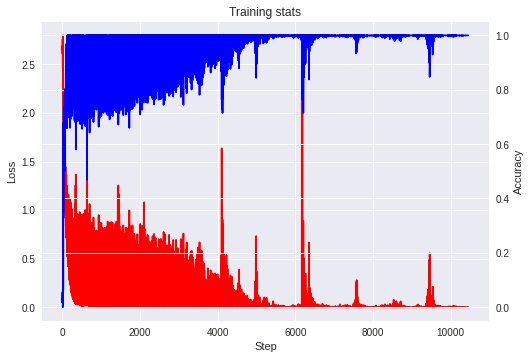

Testing.:   0%|          | 0/11 [00:00<?, ?it/s]

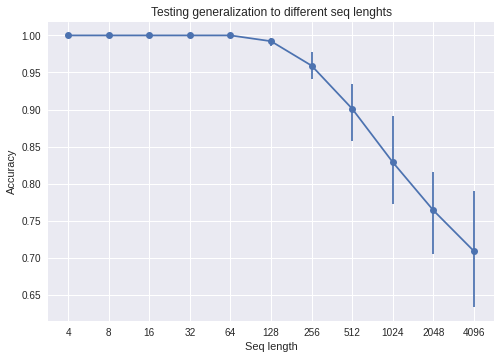

In [3]:
def generate_dup_batch(max_out_length, batch_size, n_classes=13):
    x = [torch.randint(1, n_classes, (np.random.randint(1, max_out_length // 2),)) for _ in
         range(batch_size)]
    xx = [a.repeat(2) for a in x]
    inp = nn.utils.rnn.pad_sequence(x, batch_first=True)
    inp = F.pad(inp, (0, max_out_length - inp.shape[-1]))
    res = nn.utils.rnn.pad_sequence(xx, batch_first=True)
    res = F.pad(res, (0, max_out_length - res.shape[-1]))
    return inp, res

model = SeqModel(192, 13, n_blocks=1)
training_loop(model, generate_dup_batch, device=device)
test_lengths(model, generate_dup_batch, device=device)

Training. Loss: , Acc:   0%|          | 0/50000 [00:00<?, ?it/s]

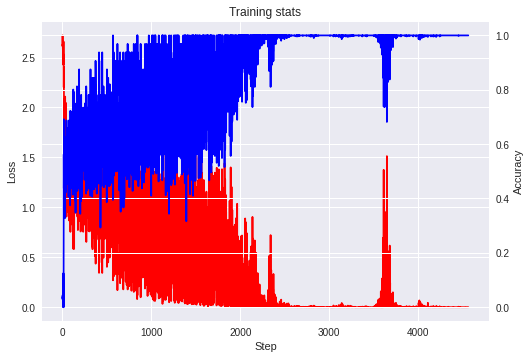

Testing.:   0%|          | 0/11 [00:00<?, ?it/s]

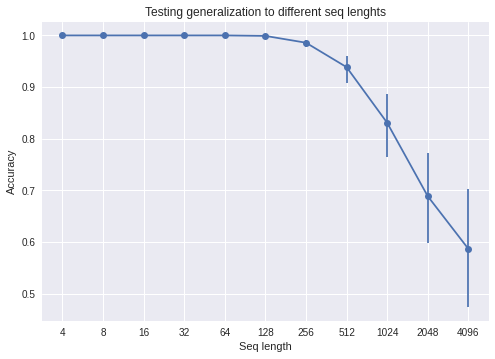

In [4]:
def generate_reverse_batch(max_out_length, batch_size, n_classes=13):
    xs = [torch.randint(1, n_classes, (np.random.randint(1, max_out_length),)) for _ in
         range(batch_size)]
    inp = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    inp = F.pad(inp, (0, max_out_length - inp.shape[-1]))
    res = nn.utils.rnn.pad_sequence([torch.flip(x, (0,)) for x in xs], batch_first=True)
    res = F.pad(res, (0, max_out_length - res.shape[-1]))
    return inp, res

model = SeqModel(192, 13, n_blocks=1)
training_loop(model, generate_reverse_batch, device=device)
test_lengths(model, generate_reverse_batch, device=device)

Training. Loss: , Acc:   0%|          | 0/50000 [00:00<?, ?it/s]

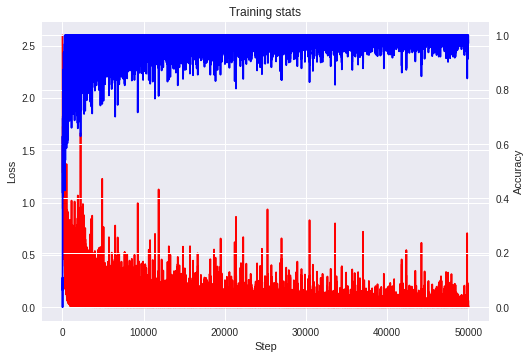

Testing.:   0%|          | 0/11 [00:00<?, ?it/s]

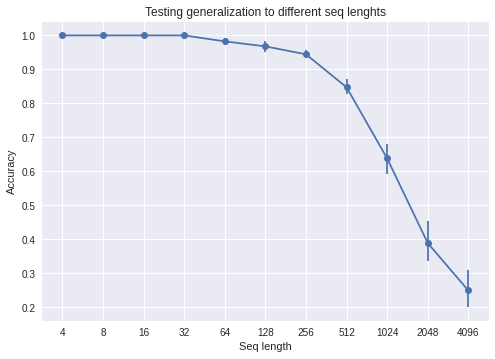

In [5]:
def generate_sorting_batch(max_out_length, batch_size, n_classes=13):
    xs = [torch.randint(1, n_classes, (np.random.randint(1, max_out_length),)) for _ in
         range(batch_size)]
    inp = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    inp = F.pad(inp, (0, max_out_length - inp.shape[-1]))
    res = nn.utils.rnn.pad_sequence([torch.sort(x)[0] for x in xs], batch_first=True)
    res = F.pad(res, (0, max_out_length - res.shape[-1]))
    return inp, res

model = SeqModel(192, 13, n_blocks=1)
training_loop(model, generate_sorting_batch, device=device)
test_lengths(model, generate_sorting_batch, device=device)

In [ ]:
def add(n1, n2, base=10):
    """Add two numbers represented as lower-endian digit lists."""
    k = max(len(n1), len(n2)) + 1
    d1 = n1 + [0 for _ in range(k - len(n1))]
    d2 = n2 + [0 for _ in range(k - len(n2))]
    res = []
    carry = 0
    for i in range(k):
        if d1[i] + d2[i] + carry < base:
            res.append(d1[i] + d2[i] + carry)
            carry = 0
        else:
            res.append(d1[i] + d2[i] + carry - base)
            carry = 1
    while res and res[-1] == 0:
        res = res[:-1]
    if res: return res
    return [0]


def generate_add_batch(max_out_length, batch_size, base=10):
    inp_lenghts = np.random.randint(3, max_out_length+1, batch_size)
    xs = []
    ys = []
    for l in inp_lenghts:
        x = torch.randint(base, size=(l,))
        sep_pos = np.random.randint(1, l-1)
        y = torch.tensor(add(x[:sep_pos].tolist(), x[sep_pos+1:].tolist()), dtype=int)
        x = x + 1   # shift, so pad is 0
        y = y + 1
        x[sep_pos] = base+1   # sep token
        xs.append(x)
        ys.append(y)
    x_tensor = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    y_tensor = nn.utils.rnn.pad_sequence(ys, batch_first=True)
    x_tensor = F.pad(x_tensor, (0, max_out_length - x_tensor.shape[1]))
    y_tensor = F.pad(y_tensor, (0, max_out_length - y_tensor.shape[1]))
    return x_tensor, y_tensor

model = SeqModel(192, 12, n_blocks=1)
training_loop(model, generate_add_batch, device=device)
test_lengths(model, generate_add_batch, device=device)
